In [2]:
import wfdb
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
import pandas as pd
from scipy.signal import butter, filtfilt

In [3]:
#limpiar carpeta de archivos
def limpiar_carpeta(carpeta):
    for file in os.listdir(carpeta):
        os.remove(carpeta+'/'+file)

Primero se leen las caracteristicas de las señales y se importa la misma.

In [4]:
def get_name_files(path,type):
    files = []
    for file in os.listdir(path):
        if file.endswith(type):
            files.append(file[:-4])
    return files

def read_file_hea(filename, path):
    # lee archivo .hea
    record = wfdb.rdheader(path+filename)
    return record

def read_file_mat(file, path):
    # carga archivo .mat (tiene las señales)
    mat_data = loadmat(path + file +'.mat')
    signals = mat_data['val']
    return signals

Se crea una forma de revisar de forma gráfica cada ECG

In [5]:
#función para graficar una cantidad de señales general
def grafica_ecg(record, signals, path_save,picos_r=None):
    #grafica las señales ecg
    plt.figure(figsize=(12, 6))
    for i in range(len(record.sig_name)):
        plt.subplot(len(record.sig_name), 1, i+1)
        plt.plot(signals[i, :], label=f'Señal: {record.sig_name[i]}')
        if picos_r is not None:
            plt.plot(picos_r, signals[i, picos_r], 'ro', markersize=1)
            #Imprime los picos_r
            print(f'Picos R señal {record.sig_name[i]}: {picos_r}')

        plt.xlabel('Muestras')
        plt.ylabel(record.units[i])
        plt.legend()
    #agregar comentarios
    plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
    # genera jpg
    plt.savefig(path_save + record.record_name + '.jpg')
    plt.close()

def graf_signals(files, path, cant, path_save):
    for fileName in files[:cant]:
        print('Graficando señales de: ', fileName)
        record = read_file_hea(fileName, 'data/training/')
        signals= read_file_mat(fileName, path) 
        #picos_r = sio.loadmat(path +file+'.mat')['picos_r']
        grafica_ecg(record,signals, path_save)

Se observan las características de los archivos.

In [6]:
# path de los archivos iniciales
old_path='data/training/'
#toma los nombres de los archivos .hea
nameFiles = get_name_files(old_path,'.hea')
#revisa el primer archivo .hea
heaRecord1 = read_file_hea(nameFiles[0], old_path)
print(heaRecord1.__dict__)


{'record_name': 'a103l', 'n_sig': 3, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 82500, 'base_time': None, 'base_date': None, 'comments': ['Asystole', 'False alarm'], 'sig_name': ['II', 'V', 'PLETH'], 'p_signal': None, 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['a103l.mat', 'a103l.mat', 'a103l.mat'], 'fmt': ['16', '16', '16'], 'samps_per_frame': [1, 1, 1], 'skew': [None, None, None], 'byte_offset': [24, 24, 24], 'adc_gain': [7247.0, 10520.0, 12530.0], 'baseline': [0, 0, 0], 'units': ['mV', 'mV', 'NU'], 'adc_res': [16, 16, 16], 'adc_zero': [0, 0, 0], 'init_value': [-171, 9127, 6042], 'checksum': [-27403, -301, -17391], 'block_size': [0, 0, 0]}


# Análisis de calidad y eliminación de la desviación de la línea base. 
Para el análisis de calidad, se verificó la presencia de líneas planas y líneas en zigzag en las señales.

Las líneas planas o en zigzag son segmentos de señales que tienen
una actividad eléctrica casi nula. Los segmentos de señal que tienen
una diferencia de amplitud cero entre dos muestras consecutivas,
durante un mínimo de dos segundos, se clasificaron como "líneas
planas". Los segmentos de señal que tienen pendientes positivas y
negativas alternas entre dos muestras sucesivas, durante un mínimo
de segundos, se clasificaron como líneas en zigzag.


Para la eliminación de la desviación de la línea base se aplicó un filtro de paso bajo Butterworth bidireccional de segundo orden con una frecuencia de corte de 1 Hz a las señales
del ECG.

## Proceso para identificar segmentos zigzag (pendiente aún):
Cálculo de la pendiente: Evaluamos la diferencia entre muestras consecutivas para obtener la pendiente. Una pendiente positiva se da cuando el valor aumenta, y una negativa cuando el valor disminuye.

Alternancia de signos: Un zigzag ocurre cuando la pendiente cambia de signo (de positiva a negativa o viceversa).

Duración mínima: Controlamos que la alternancia ocurra durante un número mínimo de segundos, es decir, durante un número determinado de muestras consecutivas.

In [7]:

# filtro butterworth
def butter_bandpass_filter(data, cutoff=1, fs=250, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(ecg_signal, lowcut=0.5, highcut=50.0, fs=250, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

#marcas
def mark_flat_lines(signal, fs=250, min_duration=0.2, flat_value=-9999, threshold=7):
    """
    Marca líneas planas en la señal donde la diferencia entre valores consecutivos es menor que un umbral.

    Parameters:
    - signal: La señal a analizar (ECG o PPG).
    - fs: Frecuencia de muestreo en Hz.
    - min_duration: Duración mínima en segundos para que se considere una línea plana.
    - flat_value: El valor que se utilizará para marcar las líneas planas en la señal.
    - threshold: Umbral de diferencia entre muestras consecutivas para considerar una línea plana.
    
    Returns:
    - marked_signal: La señal con las líneas planas marcadas.
    - flat_areas: Lista de tuplas (inicio, fin) que indican las áreas planas detectadas.
    """
    # Número de muestras consecutivas que definen una línea plana
    min_samples = int(min_duration * fs)

    # Diferencias absolutas entre muestras consecutivas
    diff_signal = np.abs(np.diff(signal))

    # Encuentra dónde la diferencia es menor que el umbral
    flat_segments = (diff_signal < threshold).astype(int)

    # Identifica segmentos planos continuos de al menos min_samples de duración
    flat_areas = []
    current_length = 0
    start_index = None

    for i in range(len(flat_segments)):
        if flat_segments[i] == 1:  # Si es un segmento plano
            if current_length == 0:
                start_index = i
            current_length += 1
        else:
            if current_length >= min_samples:  # Si cumple con la duración mínima
                flat_areas.append((start_index, start_index + current_length))
            current_length = 0

    # Considerar el último segmento si termina en una zona plana
    if current_length >= min_samples:
        flat_areas.append((start_index, start_index + current_length))

    # Marca los segmentos planos en la señal
    marked_signal = np.copy(signal)
    for start, end in flat_areas:
        marked_signal[start:end] = flat_value  # Marcar con un valor específico como -9999
    
    return marked_signal, flat_areas

def mark_zigzag_lines(signal, fs=250, min_duration=0.2):
    """
    Identifica segmentos en zigzag en una señal.
    
    Parámetros:
    signal (numpy array): La señal a analizar.
    fs (int): Frecuencia de muestreo en Hz. Por defecto es 250 Hz.
    min_duration (float): Duración mínima en segundos de un zigzag. Por defecto es 0.2 segundos.
    
    Retorna:
    zigzag_areas (list): Lista de tuplas (inicio, fin) de los segmentos en zigzag.
    """
    # Número de muestras consecutivas que definen un zigzag
    min_samples = int(min_duration * fs)
    
    # Calcula las diferencias entre muestras consecutivas (pendiente)
    diff_signal = np.diff(signal)
    
    # Determina si la pendiente es positiva o negativa
    sign_changes = np.sign(diff_signal)
    
    # Identifica los cambios de signo consecutivos (zigzag)
    zigzag_segments = (sign_changes[:-1] * sign_changes[1:] == -1).astype(int)

    # Identifica segmentos zigzag continuos de al menos min_samples de duración
    zigzag_areas = []
    current_length = 0
    start_index = None
    
    for i in range(len(zigzag_segments)):
        if zigzag_segments[i] == 1:  # Cambio de pendiente
            if current_length == 0:
                start_index = i
            current_length += 1
        else:
            if current_length >= min_samples:
                zigzag_areas.append((start_index, start_index + current_length + 1))
            current_length = 0

    # Último segmento
    if current_length >= min_samples:
        zigzag_areas.append((start_index, start_index + current_length + 1))
    
    return zigzag_areas


In [8]:
new_path='data/cleaned/'
dirty_path='data/dirty/'
if not os.path.exists(new_path):
    os.makedirs(new_path)

# Se limpian todas las señales y de dejan en el nuevo directorio
for fileName in nameFiles:
    path = old_path
    record = read_file_hea(fileName, path)
    signals = read_file_mat(fileName, path)
    # recorta y deja sólo los últimos 10 segundos de señal
    signals = signals[:, -record.fs*10:]

    # Guarda las señales sucias en un archivo .mat y .hea para ver cómo quedaron
    sio.savemat(dirty_path + fileName + '.mat', {'val': signals})

    #se aplica filtro butterworth de paso de banda
    filtered = np.array([butter_bandpass_filter(signals[i,:]) for i in range(signals.shape[0])])
    signals = signals - filtered


    
    # Aplicar filtro de paso de banda
    #signals = bandpass_filter(signals, lowcut=4,highcut=70.0, fs=250)

    
    #guara las señales limpias en un archivo .mat y .hea
    sio.savemat(new_path + fileName +'.mat', {'val': signals})

Grafica la señal aún sin procesar y guarda los gráficos un un directorio para analizarla de forma visual

In [112]:
graf_signals(nameFiles, dirty_path, len(nameFiles), 'data/imgs/cleaned/')

Graficando señales de:  a103l
Graficando señales de:  a104s
Graficando señales de:  a105l
Graficando señales de:  a109l
Graficando señales de:  a123l
Graficando señales de:  a134s
Graficando señales de:  a142s
Graficando señales de:  a145l
Graficando señales de:  a152s
Graficando señales de:  a161l
Graficando señales de:  a163l
Graficando señales de:  a165l
Graficando señales de:  a167l
Graficando señales de:  a170s
Graficando señales de:  a171l
Graficando señales de:  a172s
Graficando señales de:  a178s
Graficando señales de:  a185l
Graficando señales de:  a186s
Graficando señales de:  a203l
Graficando señales de:  a219l
Graficando señales de:  a223l
Graficando señales de:  a225l
Graficando señales de:  a226s
Graficando señales de:  a239l
Graficando señales de:  a266s
Graficando señales de:  a267l
Graficando señales de:  a272s
Graficando señales de:  a273l
Graficando señales de:  a278s
Graficando señales de:  a279l
Graficando señales de:  a287l
Graficando señales de:  a288s
Graficando

Grafica la señal filtrada y define las áreas que no se van procesadas (Líneas planas y zig-zag)

137


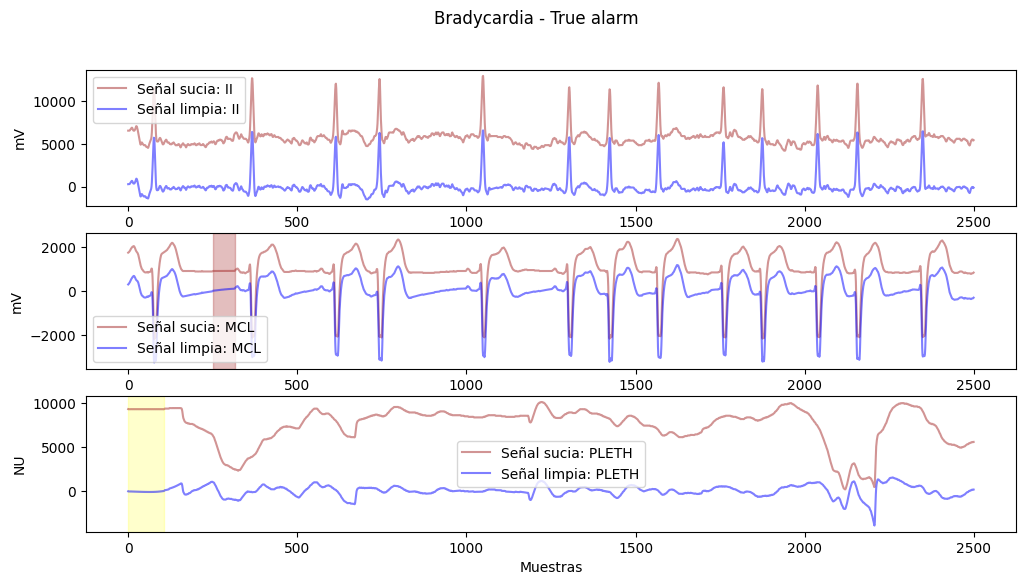

In [9]:
# graficar una señal para ver la diferencia entre la señal sucia y la limpia
# además de resaltar las áreas planas

nameFile = nameFiles.index('b269l')
print(nameFile)
signals0= read_file_mat(nameFiles[nameFile], new_path)
signals1= read_file_mat(nameFiles[nameFile], dirty_path)
record = read_file_hea(nameFiles[nameFile], old_path)

plt.figure(figsize=(12, 6))
for i in range(len(record.sig_name)):
    plt.subplot(len(record.sig_name), 1, i+1)
    plt.plot(signals1[i, :], label=f'Señal sucia: {record.sig_name[i]}', color='brown', alpha=0.5)
    plt.plot(signals0[i, :], label=f'Señal limpia: {record.sig_name[i]}', color='blue', alpha=0.5)
    
    # Marcar áreas planas y zigzags
    marked_signal, flat_areas = mark_flat_lines(signals1[i, :])
    zigzag_areas = mark_zigzag_lines(signals0[i, :])

    # Resaltar visualmente los segmentos planos de la señal sucia
    for start, end in flat_areas:
        plt.axvspan(start, end, color='brown', alpha=0.3)

    # Marcar zigzags
    for start, end in zigzag_areas:
        plt.axvspan(start, end, color='yellow', alpha=0.2)
    
    

    plt.xlabel('Muestras')
    plt.ylabel(record.units[i])
    plt.legend()
    #agregar comentarios
plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
plt.show()

Suponiendo que todas las señales egc ya están limpias, no cuenta (resp, pleth ni abp en filtro butter, osea que usan la señal sucia) se intenta hacer una prueba para identificar bradycardia extrema.

No se si debo primero identificar los picos R o dividir los datos, creo que identificaré los picos R primero.

-[ ] ok, tengo que dividir los canales de las señales de alguna forma... no el tipo de problema... EL TIPO DE CANAL
y limpiar solo las ecg

-[ ] lo que es para todos es el detector de señal plana

-[ ] y mejorar el R peaks

In [30]:
#algoritmo pan tompkinspara picor R ECG
import scipy.signal as signal
# Paso 1: Derivada de la señal
def derivada_ecg(ecg_signal):
    return np.diff(ecg_signal)

# Paso 2: Señal cuadrada
def cuadrado_ecg(derivada_signal):
    return np.square(derivada_signal)

# Paso 3: Filtro de integración móvil
def filtro_integracion(ecg_signal, window_size=10):
    window = np.ones(window_size) / window_size
    return np.convolve(ecg_signal, window, mode='same')

# Paso 4: Detección de picos
def detectar_picos(ecg_signal, threshold):
    max_val = np.max(ecg_signal)  # Encuentra el valor máximo de la señal
    
    if max_val == 0:
        print("Advertencia: El valor máximo de la señal es 0, no se puede normalizar.")
        return []  # Si el valor máximo es 0, no se puede detectar picos

    # Normalizamos la señal solo si el valor máximo es mayor que cero
    ecg_signal_normalizada = ecg_signal / max_val
    
    # Detectar los picos que superan el umbral
    picos = np.where(ecg_signal_normalizada > threshold)[0]
    
    return picos

# Función principal del algoritmo Pan-Tompkins
def pan_tompkins(ecg_signal, fs):
    # Derivar la señal
    ecg_derivada = derivada_ecg(ecg_signal)
    
    # Cuadrar la señal derivada
    ecg_cuadrada = cuadrado_ecg(ecg_derivada)
    
    # Filtrar la señal con integración
    ventana_integration = int(0.12 * fs)  # Ventana de integración, 120 ms
    ecg_integrada = filtro_integracion(ecg_cuadrada, window_size=ventana_integration)
    
    # Detectar picos R (se elimina fs como argumento extra)
    picos_r = detectar_picos(ecg_integrada, threshold=0.54) #mejor treshold probado
    
    return picos_r, ecg_cuadrada, ecg_integrada


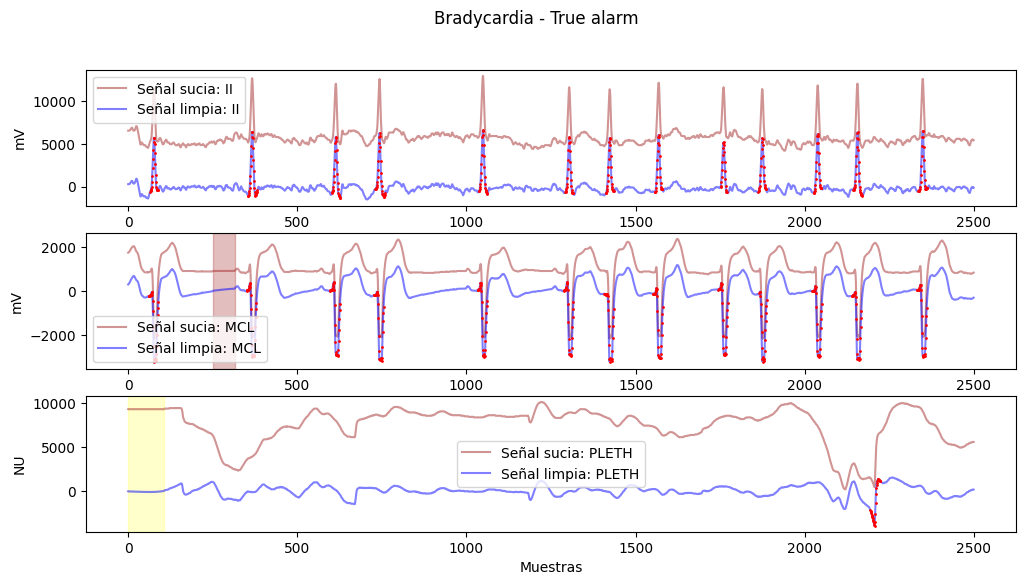

In [28]:
plt.figure(figsize=(12, 6))
for i in range(len(record.sig_name)):
    plt.subplot(len(record.sig_name), 1, i+1)
    plt.plot(signals1[i, :], label=f'Señal sucia: {record.sig_name[i]}', color='brown', alpha=0.5)
    plt.plot(signals0[i, :], label=f'Señal limpia: {record.sig_name[i]}', color='blue', alpha=0.5)
    
    # Marcar áreas planas y zigzags
    marked_signal, flat_areas = mark_flat_lines(signals1[i, :])
    zigzag_areas = mark_zigzag_lines(signals0[i, :])
    picos_r, ecg_filtrada, ecg_integrada = pan_tompkins(signals0[i, :],250)

    # Resaltar visualmente los segmentos planos de la señal sucia
    for start, end in flat_areas:
        plt.axvspan(start, end, color='brown', alpha=0.3)

    # Marcar zigzags
    for start, end in zigzag_areas:
        plt.axvspan(start, end, color='yellow', alpha=0.2)
    
    # Marcar los picos R
    for peak in picos_r:
        plt.plot(peak, signals0[i, peak], 'ro', markersize=1)  # Usar signals0 y peak para graficar correctamente

    plt.xlabel('Muestras')
    plt.ylabel(record.units[i])
    plt.legend()

plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
plt.show()
